## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the additive inflation for the dynamical and observation models

Define the time span of interest

In [5]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, tf/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [6]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [7]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

In [8]:
σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\boldsymbol{x}^i$ o generate i.i.d. samples from the system’s invariant (long-time) distribution, we sampleninitialconditions from a multivariate standard Gaussian distribution.  For each sample, we run the ODEin equation(SM.25)forT=  40,000steps using the Runge-Kutta method with a time-step of∆t= 0.01. The samples of the state at the final time are then i.i.d. samples from the push-forwarddistribution of the standard Gaussian through the nonlinear forward dynamics forTsteps

In [9]:
# Number of runs
Ne = 300
# Zero vector of the size of the state
x0 = rand(π0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz63!, x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: [-0.9358487828396777, -0.09311249871442627, -1.4687423262501977]

Create cache to store the different final solutions

In [10]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [41]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(π0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    # Store the state
    X[Ny+1:Ny+Nx,i] .= deepcopy(sol.u[1])
end
# Apply the process noise
ϵx(X, Ny+1, Ny+Nx)
# Generate the observations
observe(h, X, tf, Ny, Nx)
# Apply the observation noise
ϵy(X, 1, Ny)

In [42]:
m = 30
S = HermiteMap(m, X; diag = true)

HermiteMap(30, 6, LinearTransform(6, [0.1637251316723188, 0.07741396783819249, 25.48735446244646, -0.7477706343326249, -0.9298498351407616, 24.46425920211474], [8.70697888468096 0.0 … 0.0 0.0; 0.0 9.634967807472004 … 0.0 0.0; … ; 0.0 0.0 … 9.650537077985634 0.0; 0.0 0.0 … 0.0 8.886772715521623], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [43]:
@time optimize(S, X, "kfolds"; withqr = true, verbose = false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


  5.649203 seconds (4.31 M allocations: 6.633 GiB, 9.83% gc time)


HermiteMap(30, 6, LinearTransform(6, [0.1637251316723188, 0.07741396783819249, 25.48735446244646, -0.7477706343326249, -0.9298498351407616, 24.46425920211474], [8.70697888468096 0.0 … 0.0 0.0; 0.0 9.634967807472004 … 0.0 0.0; … ; 0.0 0.0 … 9.650537077985634 0.0; 0.0 0.0 … 0.0 8.886772715521623], true), MapComponent[Map component of dimension 1 with Nψ 7 active features
, Map component of dimension 2 with Nψ 19 active features
, Map component of dimension 3 with Nψ 19 active features
, Map component of dimension 4 with Nψ 17 active features
, Map component of dimension 5 with Nψ 18 active features
, Map component of dimension 6 with Nψ 19 active features
])

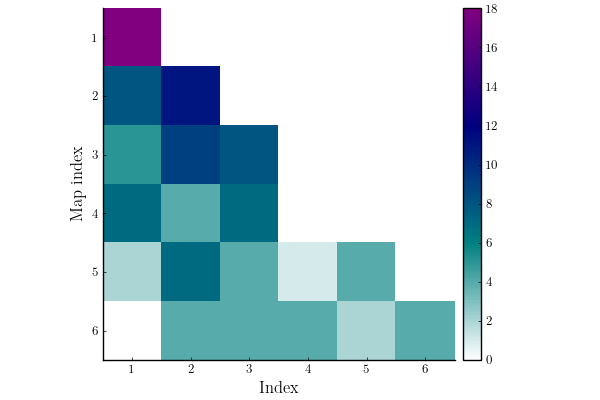

In [14]:
plot(S)

In [15]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
 2.07401e8  3.48823e7  4.79689e5      9.57769e5      5.28164e5  0.0
 3.48823e7  2.61161e9  1.77457e7      5.26545e5      2.139e9    1.91923e7
 4.79689e5  1.77457e7  1.9851e9       1.81352e5      2.06707e7  1.9492e9
 9.57769e5  5.26545e5  1.81352e5      3.52851e6  98201.5        2.30014e5
 5.28164e5  2.139e9    2.06707e7  98201.5            2.19033e9  1.78284e7
 0.0        1.91923e7  1.9492e9       2.30014e5      1.78284e7  2.17679e9

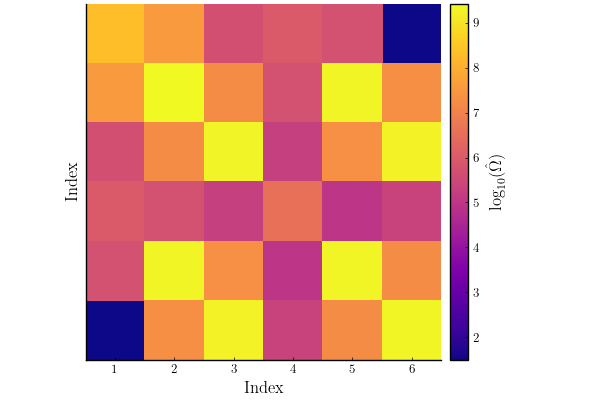

In [24]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

In [25]:
smf = StochMapFilter(x->x, ϵy, S, Ny, Nx, Δtdyn, Δtobs, Inf, false)

Stochastic Map Filter with filtered = false


In [32]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [33]:
x0 = rand(model.π0);

In [34]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [57]:
Ne = 300 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×300 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
  0.423      -1.32972   -0.877201  …  -1.34439   0.842494   -0.178307
 -0.472756    0.607271  -0.465542      1.17286  -0.315357   -0.0765101
  0.0248452   1.25278   -2.25703       0.19995  -0.0540433  -0.917753

In [58]:
Xsmf = seqassim(F, data, Tf, model.ϵx, smf, deepcopy(X), model.Ny, model.Nx, t0);

Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 98.18488409321775
1 terms - Training error: 1.409471339026854, Validation error: 1.4484739765826145
1 terms - Training error: 1.4094422892917768, Validation error: 1.4492026226123595
2 terms - Training error: 1.4089901745477267, Validation error: 1.4514693371444545
3 terms - Training error: 1.4061822441174785, Validation error: 1.4512384375784848
4 terms - Training error: 1.4033264170516444, Validation error: 1.4648584580553836
5 terms - Training error: 1.4004725364763513, Validation error: 1.4595195939734638
6 terms - Training error: 1.3940733905309435, Validation error: 1.4474549828514693
7 terms - Training error: 1.3903988157635425, Validation error: 1.473927480718905
8 terms - Training error: 1.3864595339808323, Validation error: 1.4710198152113287
9 terms - Training error: 1.3834197020516394, Validation error: 1.491518949232382
10 terms - Training error: 1.3808578822754112, Validation error: 1.4905778066954145
11 terms - Training e

12 terms - Training error: -0.01281565786047808
13 terms - Training error: -0.013211273990494984
14 terms - Training error: -0.035123939350618714
15 terms - Training error: -0.03591700665544468
16 terms - Training error: -0.036555978667340894


Progress:  33%|█████████████▋                           |  ETA: 0:00:02

17 terms - Training error: -0.03984492212709687
18 terms - Training error: -0.049567991011623035
19 terms - Training error: -0.05199776680804322
1 terms - Training error: 1.4122819149004564, Validation error: 1.4372316730882049
1 terms - Training error: 1.4122624681484564, Validation error: 1.4377582692259754
2 terms - Training error: 1.4118289702568037, Validation error: 1.4395634275106806
3 terms - Training error: 1.4086078158570345, Validation error: 1.440266568833829
4 terms - Training error: 1.406797701446729, Validation error: 1.449434284518801
5 terms - Training error: 1.403592216688612, Validation error: 1.4429816270048825
6 terms - Training error: 1.3978925873560628, Validation error: 1.4319793494077433
7 terms - Training error: 1.3933215410829982, Validation error: 1.4576346707306576
8 terms - Training error: 1.3880331974587743, Validation error: 1.4557167669124749
9 terms - Training error: 1.3855333717303338, Validation error: 1.4541044535409338
10 terms - Training error: 0.

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

16 terms - Training error: -0.044763297983821504
17 terms - Training error: -0.04637358485469421
18 terms - Training error: -0.04727926441113205
1 terms - Training error: 1.3931753945237066, Validation error: 1.5136577545952046
1 terms - Training error: 1.3920331161232309, Validation error: 1.5081678934882685
2 terms - Training error: 1.382850195024957, Validation error: 1.510549057685238
3 terms - Training error: 1.3495967818948906, Validation error: 1.506343865735998
4 terms - Training error: 1.3456117182691445, Validation error: 1.4982830256730237
5 terms - Training error: 1.3316189796151816, Validation error: 1.4988787550054794
6 terms - Training error: 1.3245279440674238, Validation error: 1.5413916732646211
7 terms - Training error: 1.127146830997228, Validation error: 1.1915451522108123
8 terms - Training error: 1.118225983465642, Validation error: 1.293700747140896
9 terms - Training error: 1.095688085412005, Validation error: 1.1322733593814724
10 terms - Training error: 1.092

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


13 terms - Training error: 1.0221317455573504
14 terms - Training error: 1.0204657374561483
15 terms - Training error: 1.0199307207739503
16 terms - Training error: 1.0185156673469233
17 terms - Training error: 1.013782001424596
18 terms - Training error: 1.0063890087363057
19 terms - Training error: 1.0062834584524418
getcoeff(M[Nypx]) = [6.242850728413914, -2.2946156690074093, -2.55164545858623, -2.5520537277753, -3.232294235538456, -1.2349317079504842, -0.543240194261392, 1.9750398799033482, 5.314768692401228, -3.6064125141307404, -10.125273650418938, -0.9087596188715735, 1.999368181643532, 1.167215846874988, -6.715677489034433, 1.4475449272187528, -2.457432717399654, 1.232680887758248, -0.10459929606416213]
"after inversion" = "after inversion"
norm(X) = 28.12744345314271
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 101.70124829065577
1 terms - Training error: 1.4007367615240718, Validation error: 1.4834122865937436
1 terms - Training error: 1.3997985349821345, Validation erro

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


2 terms - Training error: 1.3576287271904932
3 terms - Training error: 1.3546069256284314
4 terms - Training error: 1.34611335451145
5 terms - Training error: 1.3400475620299843
6 terms - Training error: 1.3371977704523688
7 terms - Training error: 1.1281007411284667
8 terms - Training error: 1.1265596185771711
9 terms - Training error: 1.1262285710874997
10 terms - Training error: 1.0809847216997666
11 terms - Training error: 1.080194095730842
12 terms - Training error: 0.9741359239367069
13 terms - Training error: 0.9736530413620531
14 terms - Training error: 0.9566560090110506
15 terms - Training error: 0.9565393534630579
16 terms - Training error: 0.955891007403386
17 terms - Training error: 0.9558705052787331
1 terms - Training error: 1.4011466151594705, Validation error: 1.4817728720521486
1 terms - Training error: 1.4001709944999612, Validation error: 1.4890763248094776
2 terms - Training error: 1.0008878696940862, Validation error: 1.0180852118340171
3 terms - Training error: 

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

17 terms - Training error: 0.45639868067939304, Validation error: 0.5137698510506673
18 terms - Training error: 0.4557167545284063, Validation error: 0.5077757297629595
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.4169140971456973
2 terms - Training error: 1.3590661244620545
3 terms - Training error: 1.3561346134692236
4 terms - Training error: 1.3483819295597241
5 terms - Training error: 1.3422997587196703
6 terms - Training error: 1.3394520178683618
7 terms - Training error: 1.1293496254166633
8 terms - Training error: 1.1278670750418491
9 terms - Training error: 1.12750594676106
10 terms - Training error: 1.0824427827467487
11 terms - Training error: 1.0815737854092022
12 terms - Training error: 0.9743489628156005
13 terms - Training error: 0.9738596239893031
14 terms - Training error: 0.9567154247835373
15 terms - Training error: 0.9566008650662283
16 terms - Training error: 0.9559353197282018
17 terms - Training error: 0.955889764298483
18 terms - Train

13 terms - Training error: 1.2522186650151659, Validation error: 1.3836177169637214
14 terms - Training error: 1.251562934187995, Validation error: 1.39051699629507
15 terms - Training error: 1.2514298714631527, Validation error: 1.3868147103095627
16 terms - Training error: 1.245074931756425, Validation error: 1.397035529695883
17 terms - Training error: 1.24322528551705, Validation error: 1.3945845650876123
18 terms - Training error: 1.243046753814939, Validation error: 1.3956650504769734
1 terms - Training error: 1.4172718665380057
1 terms - Training error: 1.416689484153574
2 terms - Training error: 1.335236197423694
3 terms - Training error: 1.3264873557377264
4 terms - Training error: 1.3171014944851447
5 terms - Training error: 1.3017040787783893
6 terms - Training error: 1.2971619561497545
7 terms - Training error: 1.2963134175920452
8 terms - Training error: 1.2951450031652147
9 terms - Training error: 1.2920450133452717
10 terms - Training error: 1.287187132667627
11 terms - 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


19 terms - Training error: 1.1423735357603464
getcoeff(M[Nypx]) = [9.244327517690648, 1.1010449507492706, 2.7770835774145977, 0.5987563867411637, -4.592256709404326, 3.2525781234419897, -0.039478501791622767, -4.696125048124088, 0.23864416789010412, -1.645669355839572, -0.06475233073795422, -3.1295325027377783, 5.565249857512678, -3.624239362384027, 5.186321796446184, -1.9485685509686705, 2.1089381531640123, -0.16817128191570563, -1.4862500507015644]
"after inversion" = "after inversion"
norm(X) = 37.456666161690855
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 60.84280983675669
1 terms - Training error: 1.4231115500395912, Validation error: 1.393913132531664
1 terms - Training error: 1.4228884984002608, Validation error: 1.3947469701024129
2 terms - Training error: 1.010762639703877, Validation error: 0.9949185991527428
3 terms - Training error: 1.0102486107541464, Validation error: 0.9939011197658264
4 terms - Training error: 0.9734127341245878, Validation error: 0.9768389069021


18 terms - Training error: 0.25184594273499733, Validation error: 0.20235142192798158
1 terms - Training error: 1.417271866538006
1 terms - Training error: 1.4171526131552927
2 terms - Training error: 1.140235734128287
3 terms - Training error: 1.1389974446279056
4 terms - Training error: 1.1056021542113348
5 terms - Training error: 1.1035916764165066
6 terms - Training error: 0.9888372530394726
7 terms - Training error: 0.9875957193170114
8 terms - Training error: 0.9874408666017247
9 terms - Training error: 0.9868513947127914
10 terms - Training error: 0.9861837798328286
11 terms - Training error: 0.9655611187060934
12 terms - Training error: 0.9654275685749748
13 terms - Training error: 0.9653745520329184
14 terms - Training error: 0.5480873608668546
15 terms - Training error: 0.5448679534170704
16 terms - Training error: 0.23631371642695437
17 terms - Training error: 0.23589168662232132

Progress:  33%|█████████████▋                           |  ETA: 0:00:01


1 terms - Training error: 1.4235257429237436, Validation error: 1.3922563609950576
1 terms - Training error: 1.4232872858394978, Validation error: 1.3931917536834695
2 terms - Training error: 1.01064965932136, Validation error: 0.9951401933606263
3 terms - Training error: 1.01014262895406, Validation error: 0.9941313106478715
4 terms - Training error: 0.9733499325744841, Validation error: 0.976614455376565
5 terms - Training error: 0.9710601689276549, Validation error: 0.9752864825287323
6 terms - Training error: 0.9709274398759127, Validation error: 0.9755029306825218
7 terms - Training error: 0.9703547800712168, Validation error: 0.9764600413104828
8 terms - Training error: 0.9680959217269829, Validation error: 0.9769305725914911
9 terms - Training error: 0.9677456720352986, Validation error: 0.977459465905861
10 terms - Training error: 0.9631077803577589, Validation error: 0.9721540120235795
11 terms - Training error: 0.9628825472986872, Validation error: 0.9729244978596696
12 term

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

17 terms - Training error: 0.23554203158136816
18 terms - Training error: 0.23302474622316768
19 terms - Training error: 0.23105511856252933
1 terms - Training error: 1.3991623540779041, Validation error: 1.489709916378414
1 terms - Training error: 1.3982981985783298, Validation error: 1.4886717108910565
2 terms - Training error: 1.3655624040516534, Validation error: 1.41496379194449
3 terms - Training error: 1.3642763676140193, Validation error: 1.42237166079315
4 terms - Training error: 1.3600018961936349, Validation error: 1.4362870657775169
5 terms - Training error: 1.3323371403888808, Validation error: 1.4959944194324886
6 terms - Training error: 1.3316538325248213, Validation error: 1.4882703852332555
7 terms - Training error: 1.329190290823211, Validation error: 1.4786091519212279
8 terms - Training error: 1.268242933842436, Validation error: 1.3354998273832335
9 terms - Training error: 1.266856860956101, Validation error: 1.3524127848006169
10 terms - Training error: 1.26591892

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


6 terms - Training error: 1.2981260054226074
7 terms - Training error: 1.2955958718959826
8 terms - Training error: 1.2741556251046906
9 terms - Training error: 1.273081064038595
10 terms - Training error: 1.2729319351562765
11 terms - Training error: 1.2714991527728767
12 terms - Training error: 1.1894977732573977
13 terms - Training error: 1.1894586549759307
getcoeff(M[Nypx]) = [-0.7097928658787032, 2.4003282909438415, 0.33894281723098957, -0.9043197410511432, -2.644529277355304, 1.778354268064969, 0.48678365138713636, 1.3996092755749086, -0.5010808362171743, 0.07172063046476414, -0.07264245733056826, -2.5463843076240114, -0.033827409014285624]
"after inversion" = "after inversion"
norm(X) = 104.45459837089932
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 280.41747351333845
1 terms - Training error: 1.3906365181203242, Validation error: 1.5238132602087329
1 terms - Training error: 1.3895872536805787, Validation error: 1.5293968151296526
2 terms - Training error: 1.224141450011426

8 terms - Training error: 1.1052828716054819
9 terms - Training error: 1.1031875332702294
10 terms - Training error: 1.0991733946625675
11 terms - Training error: 1.0968447375015935
12 terms - Training error: 1.094512126487781
13 terms - Training error: 1.094202009568607
14 terms - Training error: 0.9936727465201477
15 terms - Training error: 0.9918146306246811
16 terms - Training error: 0.908665477466372
17 terms - Training error: 0.9080273956604982
18 terms - Training error: 0.5713689973390698

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


19 terms - Training error: 0.5682612442930658
1 terms - Training error: 1.3919171106542003, Validation error: 1.5186908900732285
1 terms - Training error: 1.3907699376566054, Validation error: 1.5246759551558295
2 terms - Training error: 1.224161587285717, Validation error: 1.227325501584098
3 terms - Training error: 1.214799338960968, Validation error: 1.2512779127527
4 terms - Training error: 0.967461519797546, Validation error: 1.0386761831288647
5 terms - Training error: 0.9670815462138268, Validation error: 1.038623388580673
6 terms - Training error: 0.9611204160946281, Validation error: 1.0371807810306068
7 terms - Training error: 0.9597382602697864, Validation error: 1.0442641358852691
8 terms - Training error: 0.9502177879620661, Validation error: 1.045267857721251
9 terms - Training error: 0.9500009468358845, Validation error: 1.0489229916451686
10 terms - Training error: -0.4515066027623175, Validation error: 0.9938719772807953
11 terms - Training error: -0.45510721762617157

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

18 terms - Training error: 0.7037254530169139
19 terms - Training error: 0.5743233598088102
1 terms - Training error: 1.3839374968240876, Validation error: 1.550609345393681
1 terms - Training error: 1.3835263326054916, Validation error: 1.5530300350021946
2 terms - Training error: 1.2524747770545948, Validation error: 1.2860796730082629
3 terms - Training error: 1.2388549770002286, Validation error: 1.3060669832993037
4 terms - Training error: 1.0212882327528605, Validation error: 1.1241379486627496
5 terms - Training error: 1.017337006611595, Validation error: 1.1227440669174211
6 terms - Training error: 1.0131879525016336, Validation error: 1.1148498739615902
7 terms - Training error: 1.011451203811089, Validation error: 1.111813152972561
8 terms - Training error: 0.65145788643829, Validation error: 0.6852616785108291
9 terms - Training error: 0.6504191507570672, Validation error: 0.6911824009080841
10 terms - Training error: 0.6392278711582366, Validation error: 0.6907977167689239


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


15 terms - Training error: 0.35195346887582907
16 terms - Training error: 0.3430853873661122
17 terms - Training error: 0.34041393806518244
getcoeff(M[Nypx]) = [18.33976642399125, 9.999258275348026, 8.291217143663896, 7.567679551772746, 3.480269473730898, 2.370415539251548, 1.0113146656717253, -1.6612852235744546, -1.276232787772541, -1.3967321964375856, -15.232064440760215, 9.699614204848197, -7.2242606429795435, 4.732148736977148, -0.37132058693502346, -0.8805433161608806, -1.9888872807490197]
"after inversion" = "after inversion"
norm(X) = 295.4469800653458
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 851.2316911527831
1 terms - Training error: 1.4165245711448953, Validation error: 1.420261048110448
1 terms - Training error: 1.4162070717014048, Validation error: 1.422745368186357
2 terms - Training error: 1.3534156956566017, Validation error: 1.3192687168219654
3 terms - Training error: 1.3498793838328138, Validation error: 1.3242642053971319
4 terms - Training error: 1.0282488

14 terms - Training error: 0.4767908602968207, Validation error: 0.5481440740148854
15 terms - Training error: 0.4760380012876531, Validation error: 0.545180263399288
16 terms - Training error: 0.46953148090168995, Validation error: 0.5372110353175771
17 terms - Training error: 0.46868347117246356, Validation error: 0.5310271848514936
18 terms - Training error: 0.33449636545986633, Validation error: 0.36688810757350193
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.417196494144794
2 terms - Training error: 1.0328498227392537
3 terms - Training error: 1.0327998562063032
4 terms - Training error: 1.0232966954691558
5 terms - Training error: 1.0232580966020572
6 terms - Training error: 1.019369789620315
7 terms - Training error: 1.0183043445060478
8 terms - Training error: 1.0124893653864624
9 terms - Training error: 1.0109031987347132
10 terms - Training error: 1.0105633980800008
11 terms - Training error: 0.6576326070572263
12 terms - Training error: 0.65688811

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


18 terms - Training error: 0.5695493558868933
19 terms - Training error: 0.382154327458066
1 terms - Training error: 1.4223664937182414, Validation error: 1.396893357817064
1 terms - Training error: 1.421779294937951, Validation error: 1.3987645683074388
2 terms - Training error: 1.2036540518559045, Validation error: 1.1308480496125959
3 terms - Training error: 1.2004551590978474, Validation error: 1.1125718214771398
4 terms - Training error: 1.1603923373020113, Validation error: 1.1021463870469033
5 terms - Training error: 1.1553903372437495, Validation error: 1.1033620911241588
6 terms - Training error: 1.0531659347220346, Validation error: 0.9849802040252231
7 terms - Training error: 1.0516687476156783, Validation error: 0.9932265813970012
8 terms - Training error: 1.0259716091215536, Validation error: 0.952525608935242
9 terms - Training error: 1.0251791104322898, Validation error: 0.9457156399875113
10 terms - Training error: 1.0125310602972972, Validation error: 0.91505680912695

13 terms - Training error: 0.9145187357593879
14 terms - Training error: 0.9096879483573668
15 terms - Training error: 0.9047813629473487
16 terms - Training error: 0.9037812288326421
17 terms - Training error: 0.7413184176832888
18 terms - Training error: 0.7188532829399437


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

19 terms - Training error: 0.5200031876211153
1 terms - Training error: 1.4151342276539376, Validation error: 1.425822422074282
1 terms - Training error: 1.4148711789830892, Validation error: 1.4280027394737287
2 terms - Training error: 1.3726502840732637, Validation error: 1.3423737560251063
3 terms - Training error: 1.367530778561463, Validation error: 1.3477381593565514
4 terms - Training error: 1.0136732110861593, Validation error: 0.9969540700087085
5 terms - Training error: 1.0124603715563463, Validation error: 0.9997210734674115
6 terms - Training error: 1.010832683965524, Validation error: 1.0013288457580085
7 terms - Training error: 1.009227108979515, Validation error: 1.000255425580714
8 terms - Training error: 1.0041695669163577, Validation error: 0.9975743105581633
9 terms - Training error: 1.0032936555911747, Validation error: 0.9931049212498412
10 terms - Training error: 0.9943544373068252, Validation error: 0.9849518858665628
11 terms - Training error: 0.9931610252715372

11 terms - Training error: 0.5505026895561439
12 terms - Training error: 0.5502434528769823
13 terms - Training error: 0.5475607482848178
14 terms - Training error: 0.2926755041531674
15 terms - Training error: 0.28856943558528503
16 terms - Training error: 0.2573671372719013


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


17 terms - Training error: 0.2549705983728951
18 terms - Training error: 0.2487301603464492
19 terms - Training error: 0.24748818122907165
getcoeff(M[Nypx]) = [0.6359944710742441, -8.349728124551946, 2.5354633705171596, 2.901349827556281, -0.5364675273962056, -3.8135860115554836, 1.3355905977687423, 11.002139471254337, -1.1374803833777933, 0.6133082182097418, -3.358415893896126, -0.5804704401008346, -0.07353274613086958, 5.7994947667542345, 2.4088515337994423, 1.737292522116776, -1.496639150876712, -0.7157500334250113, 0.7703526566715214]
"after inversion" = "after inversion"
norm(X) = 626.548837458047
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 1258.3559132758407
1 terms - Training error: 1.4187964584116761, Validation error: 1.4111734990433258
1 terms - Training error: 1.408089475155069, Validation error: 1.4053844392729855
2 terms - Training error: 1.2331650845373863, Validation error: 1.3066444053172366
3 terms - Training error: 1.128188712416502, Validation error: 1.19412567

16 terms - Training error: 0.8266632932041451, Validation error: 0.7951160182752657
17 terms - Training error: 0.8252255289666245, Validation error: 0.808036953867025
18 terms - Training error: 0.7987477270393538, Validation error: 0.8101630336329895
1 terms - Training error: 1.417271866538006
1 terms - Training error: 1.4075244173898978
2 terms - Training error: 1.2473607424450863
3 terms - Training error: 1.1411271841170296
4 terms - Training error: 1.1158562584652396
5 terms - Training error: 1.0966361803927298
6 terms - Training error: 0.9537056527353535
7 terms - Training error: 0.936129399690973
8 terms - Training error: 0.9067755903928036
9 terms - Training error: 0.9024362100301045
10 terms - Training error: 0.8823182133755487
11 terms - Training error: 0.8801293391478724
12 terms - Training error: 0.8316840405939063
13 terms - Training error: 0.8299999834608568
14 terms - Training error: 0.8096326410183422

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


15 terms - Training error: 0.8090222351900833
16 terms - Training error: 0.7980644198659694
17 terms - Training error: 0.7907277257153295
18 terms - Training error: 0.7899132241621248
1 terms - Training error: 1.4175332116157895, Validation error: 1.4162264862268712
1 terms - Training error: 1.4094340854084488, Validation error: 1.4175012506167033
2 terms - Training error: 1.3122038483905265, Validation error: 1.3600965677420431
3 terms - Training error: 1.2929495355489813, Validation error: 1.352149010898668
4 terms - Training error: 1.2728539827183014, Validation error: 1.3016328753733968
5 terms - Training error: 1.2584761926909396, Validation error: 1.2794511539481566
6 terms - Training error: 1.1738125551817165, Validation error: 1.2339105837351545
7 terms - Training error: 1.1227673121253436, Validation error: 1.210092837795654
8 terms - Training error: 1.097087360094769, Validation error: 1.1771146421108944
9 terms - Training error: 1.0824787440923527, Validation error: 1.16286

6 terms - Training error: 1.1855710071648007
7 terms - Training error: 1.139475229963271
8 terms - Training error: 1.1125129627587984
9 terms - Training error: 1.0976106622594912
10 terms - Training error: 1.0958198091032443
11 terms - Training error: 1.08557903307089
12 terms - Training error: 1.0829530275091024
13 terms - Training error: 1.051101954122728
14 terms - Training error: 1.041899625114059


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

15 terms - Training error: 1.038350832238043
16 terms - Training error: 1.0341695600862486
17 terms - Training error: 1.033564215254888
1 terms - Training error: 1.416721178200997, Validation error: 1.419474619886042
1 terms - Training error: 1.4020797730215762, Validation error: 1.4109875858007772
2 terms - Training error: 1.144971231065603, Validation error: 1.1361288981719417
3 terms - Training error: 1.0577034869898245, Validation error: 1.06954088699005
4 terms - Training error: 1.0264042402167004, Validation error: 1.0553172643863804
5 terms - Training error: 0.9885977861437133, Validation error: 1.036058910274449
6 terms - Training error: 0.6859759230707547, Validation error: 0.7534531360555206
7 terms - Training error: 0.42255312200678236, Validation error: 0.49706980113931776
8 terms - Training error: 0.22932364283171167, Validation error: 0.40072808609125815
9 terms - Training error: 0.17859245001455623, Validation error: 0.34720764612858673
10 terms - Training error: 0.11619

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


12 terms - Training error: -1.050683686655633
13 terms - Training error: -1.3365073750521543
14 terms - Training error: -1.4045147848498545
15 terms - Training error: -1.4107152610358193
16 terms - Training error: -1.4117687677651027
17 terms - Training error: -1.4450957025922344
getcoeff(M[Nypx]) = [-131.35643744698248, 59.583019604350156, -76.5767101377849, 10.595586596546319, -29.908822551578012, 4.093329062254634, 110.65973608484082, 46.552976367224055, -14.869478982484273, 34.94352065470374, 41.779753512922355, 12.460269763599737, -33.048458711381144, 12.460451484373584, -0.7957341873929562, -0.12482366543500081, -6.166243042967978]
"after inversion" = "after inversion"
norm(X) = 987.1894255185945
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 897.8341692918265
1 terms - Training error: 1.3904131358307599, Validation error: 1.5247067893669888
1 terms - Training error: 1.389004147744947, Validation error: 1.5283322451173917
2 terms - Training error: 1.3874323232920347, Validatio

16 terms - Training error: 1.1197955367269319, Validation error: 1.1330455090078655
17 terms - Training error: 1.1180481351197211, Validation error: 1.1424647154499488
18 terms - Training error: 1.117146556349132, Validation error: 1.1391880372293866
1 terms - Training error: 1.4172718665380055
1 terms - Training error: 1.4166918425190753
2 terms - Training error: 1.4133712527460158
3 terms - Training error: 1.409438830005141
4 terms - Training error: 1.3990398892592277
5 terms - Training error: 1.3936903386388932
6 terms - Training error: 1.2852170955823925
7 terms - Training error: 1.2680535917424791
8 terms - Training error: 1.256223230771664
9 terms - Training error: 1.2528648027439744
10 terms - Training error: 1.2523476257661152
11 terms - Training error: 1.2514042734416821
12 terms - Training error: 1.2115291606866037
13 terms - Training error: 1.2102556967372546
14 terms - Training error: 1.1431207241529093
15 terms - Training error: 1.1420163652239281
16 terms - Training error

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


19 terms - Training error: 1.0687357202416319
1 terms - Training error: 1.388894156617555, Validation error: 1.5307827062198105
1 terms - Training error: 1.3863245099292187, Validation error: 1.5346875733224044
2 terms - Training error: 1.3814464535781343, Validation error: 1.5406876396516767
3 terms - Training error: 1.3181127781595554, Validation error: 1.5286125249908076
4 terms - Training error: 1.311167413173691, Validation error: 1.4895854373237702
5 terms - Training error: 1.3048870605833174, Validation error: 1.4789963050526975
6 terms - Training error: 1.2894453659685863, Validation error: 1.4728164192216586
7 terms - Training error: 1.2798860637713079, Validation error: 1.4549916835888035
8 terms - Training error: 0.6187581734002776, Validation error: 0.7748711290556887
9 terms - Training error: 0.6094233993949851, Validation error: 0.7222734750222948
10 terms - Training error: 0.41122978544865846, Validation error: 0.5238676636863869
11 terms - Training error: 0.40633320423

5 terms - Training error: 0.9861641867307511
6 terms - Training error: 0.6349596247651484
7 terms - Training error: 0.5736632812580538
8 terms - Training error: 0.4721365101247375
9 terms - Training error: 0.4660879112301664
10 terms - Training error: 0.4285062352037972
11 terms - Training error: 0.42361386224662895
12 terms - Training error: 0.4032192014986365
13 terms - Training error: 0.40082945828626293
14 terms - Training error: 0.4001241818016156
15 terms - Training error: 0.38640382094281106
16 terms - Training error: 0.3861948782133038
17 terms - Training error: 0.3851293728356227
18 terms - Training error: 0.37570935910018655


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

19 terms - Training error: 0.31771326978923525
1 terms - Training error: 1.400774002662086, Validation error: 1.4832633220416866
1 terms - Training error: 1.3981650258219285, Validation error: 1.4826085718006061
2 terms - Training error: 1.3782937588494628, Validation error: 1.4515400087517996
3 terms - Training error: 1.3143699848386394, Validation error: 1.4137283925829516
4 terms - Training error: 1.288333739565483, Validation error: 1.3841723083205646
5 terms - Training error: 1.2754263735949645, Validation error: 1.3654759078807648
6 terms - Training error: 1.215561422647459, Validation error: 1.2745658238006554
7 terms - Training error: 1.2008130890413806, Validation error: 1.3563847465313765
8 terms - Training error: 1.1988912424798117, Validation error: 1.3490403253960517
9 terms - Training error: 1.1963782009490933, Validation error: 1.3364779640783435
10 terms - Training error: 1.1776016108969343, Validation error: 1.314271840684471
11 terms - Training error: 1.17400318893334

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


12 terms - Training error: 0.7755523629402092
13 terms - Training error: 0.7737494074752529
14 terms - Training error: 0.7728161942856497
15 terms - Training error: 0.7695246010819531
getcoeff(M[Nypx]) = [5.088516355227053, 3.80973059252649, 2.5249731751094417, 0.5819616214454667, -3.0167065655638265, 8.839963136818277, -0.9808321712836678, -0.2388261853058817, -2.2530736247926586, -7.630943455698073, -3.754474798380177, 1.3904146094613201, 0.6471160687517026, -0.11689794193260067, -0.9151478398868326]
"after inversion" = "after inversion"
norm(X) = 668.1403468730159
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 709.1095077091661
1 terms - Training error: 1.398872372279243, Validation error: 1.4908698435730583
1 terms - Training error: 1.3910209757652703, Validation error: 1.5073453546766582
2 terms - Training error: 1.3438384871526934, Validation error: 1.4653777356909965
3 terms - Training error: 1.3131375662883291, Validation error: 1.4480122437191185
4 terms - Training error: 1

16 terms - Training error: 0.9672286649958821, Validation error: 0.9756227443383207
17 terms - Training error: 0.9634620861849472, Validation error: 0.9114225319179998
18 terms - Training error: 0.9560427579040371, Validation error: 0.8850802422849462
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.4135381553094892
2 terms - Training error: 1.3676458509840734
3 terms - Training error: 1.3394045883485293
4 terms - Training error: 1.3007628820253179
5 terms - Training error: 1.256505195525483
6 terms - Training error: 1.2361103433663645
7 terms - Training error: 1.2323968154483023
8 terms - Training error: 1.182693653260136
9 terms - Training error: 1.1758916241487867
10 terms - Training error: 1.132766490399565
11 terms - Training error: 1.0586556862088006
12 terms - Training error: 1.0553859836954662
13 terms - Training error: 1.0550199598258336
14 terms - Training error: 1.021051469353712
15 terms - Training error: 1.0131013496168386

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


16 terms - Training error: 1.0011671501031467
17 terms - Training error: 0.9952881857050346
18 terms - Training error: 0.9906429342738411
1 terms - Training error: 1.3912140296953879, Validation error: 1.5215032139084779
1 terms - Training error: 1.3807730564974623, Validation error: 1.5405682569527404
2 terms - Training error: 1.3188893102955335, Validation error: 1.4583753146451472
3 terms - Training error: 1.2925716076292655, Validation error: 1.4485426366232168
4 terms - Training error: 1.2380454545174238, Validation error: 1.3664219114298617
5 terms - Training error: 1.1950820448763417, Validation error: 1.3161029392301524
6 terms - Training error: 1.1616475002389641, Validation error: 1.2313140395814075
7 terms - Training error: 0.880727076101895, Validation error: 0.9832605414901648
8 terms - Training error: 0.22628278925274356, Validation error: 0.38634548496211374
9 terms - Training error: 0.10247020416721057, Validation error: 0.1668486993337709
10 terms - Training error: -0

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

5 terms - Training error: 0.8921410907364613
6 terms - Training error: 0.22115143025322295
7 terms - Training error: -0.04555908268890643
8 terms - Training error: -0.1664465583914003
9 terms - Training error: -0.1712844094989673
10 terms - Training error: -0.19487645207805623
11 terms - Training error: -0.2152493439825891
12 terms - Training error: -0.2162761113472031
13 terms - Training error: -0.21748697946345857
1 terms - Training error: 1.4053696330918064, Validation error: 1.464880800322805
1 terms - Training error: 1.3916257143241517, Validation error: 1.473400432998068
2 terms - Training error: 1.1171200162527153, Validation error: 1.1068889420682906
3 terms - Training error: 1.0787446434221943, Validation error: 1.0458197889254737
4 terms - Training error: 1.059076959176704, Validation error: 1.0396554366192279
5 terms - Training error: 1.0063743223226433, Validation error: 1.02296965468849
6 terms - Training error: 0.586073723482375, Validation error: 0.7150653935386508
7 ter

9 terms - Training error: 0.5620713456196132
10 terms - Training error: 0.5592379412966353
11 terms - Training error: 0.5372573253510367
12 terms - Training error: 0.16212039458338964
13 terms - Training error: -0.027248244532343036
14 terms - Training error: -0.11559087644986935
15 terms - Training error: -0.14370527862336024
16 terms - Training error: -0.145412902756325
17 terms - Training error: -0.15073379694133243


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


18 terms - Training error: -0.1515805039129064
getcoeff(M[Nypx]) = [21.937079114263884, 13.856705624147617, 11.967597953145265, 1.1173671790316793, 12.08408594828858, 13.905310439313896, 6.502746735436665, 3.0342728471562936, -0.90222451667904, -0.22963841473556176, -35.39184437530376, -28.270098649178884, -21.157493594098955, -8.812767110252155, -4.607971097792061, 0.5180030976294487, 0.2728319296727641, 0.3996771125217394]
"after inversion" = "after inversion"
norm(X) = 489.04167567733856
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 630.0055446590279
1 terms - Training error: 1.3978825799188104, Validation error: 1.4948290130147854
1 terms - Training error: 1.3953404123881246, Validation error: 1.5151812025629843
2 terms - Training error: 1.358736624217241, Validation error: 1.4204919386766153
3 terms - Training error: 1.3570590642695708, Validation error: 1.4225138587246393
4 terms - Training error: 1.2998704848028517, Validation error: 1.3826035392936284
5 terms - Training err

18 terms - Training error: 1.173334599817677, Validation error: 1.2504523882532852
1 terms - Training error: 1.4172718665380055
1 terms - Training error: 1.4171216097517014
2 terms - Training error: 1.3963901682366011
3 terms - Training error: 1.3936845932554687
4 terms - Training error: 1.373418905892001
5 terms - Training error: 1.3707675145234173
6 terms - Training error: 1.3599547071244475
7 terms - Training error: 1.3510043249806971
8 terms - Training error: 1.3196529468959666
9 terms - Training error: 1.319226419604905
10 terms - Training error: 1.2856700703067538
11 terms - Training error: 1.2825881536724801
12 terms - Training error: 1.240061286914704
13 terms - Training error: 1.2395017606166092
14 terms - Training error: 1.1805671514398095
15 terms - Training error: 1.1781341672741557
16 terms - Training error: 1.177218489441821

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


17 terms - Training error: 1.164853589425033
18 terms - Training error: 1.164757693402713
1 terms - Training error: 1.4031141483071612, Validation error: 1.4739027394613844
1 terms - Training error: 1.401520372609175, Validation error: 1.4835274792195157
2 terms - Training error: 1.3876091821775964, Validation error: 1.5564879452869593
3 terms - Training error: 1.071675097847085, Validation error: 1.1310954789832326
4 terms - Training error: 0.8314474361159475, Validation error: 0.9998283585208444
5 terms - Training error: 0.8274485031826168, Validation error: 1.0011767908424254
6 terms - Training error: 0.7655385723244648, Validation error: 0.9314653007424905
7 terms - Training error: 0.7600988990215864, Validation error: 0.9450478594573276
8 terms - Training error: 0.7236676927554268, Validation error: 0.8879597443506968
9 terms - Training error: 0.7207024643158685, Validation error: 0.8765682981975591
10 terms - Training error: 0.7104449250988207, Validation error: 0.86804412500097

11 terms - Training error: 1.306559804096884
12 terms - Training error: 0.7872966176971967
13 terms - Training error: 0.7810769967245513
14 terms - Training error: 0.6481601937313736
15 terms - Training error: 0.6463305602175314
16 terms - Training error: 0.6281187236438761


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

17 terms - Training error: 0.6268562786998254
18 terms - Training error: 0.6066270358980982
19 terms - Training error: 0.6029703756327501
1 terms - Training error: 1.3913215339892315, Validation error: 1.521073196733102
1 terms - Training error: 1.3873814568999219, Validation error: 1.5528860950684973
2 terms - Training error: 1.3366972020949428, Validation error: 1.4571023595671784
3 terms - Training error: 1.2914688911166894, Validation error: 1.52508813111548
4 terms - Training error: 1.1213243259542414, Validation error: 1.359936288733007
5 terms - Training error: 1.1137221253453182, Validation error: 1.3538214244273847
6 terms - Training error: 1.083837138253285, Validation error: 1.362242132927796
7 terms - Training error: 1.079294153579507, Validation error: 1.396360326150141
8 terms - Training error: 1.0380669349703848, Validation error: 1.1773551923212826
9 terms - Training error: 1.036876878159825, Validation error: 1.1758887665319628
10 terms - Training error: 1.036464163992

10 terms - Training error: 1.0607132397047712
11 terms - Training error: 1.0580855591678373
12 terms - Training error: 1.0544409535542851
13 terms - Training error: 1.0541590665584273
14 terms - Training error: 1.05302384392926
15 terms - Training error: 1.0523483986364737
16 terms - Training error: 1.0034653652556897
17 terms - Training error: 1.002119401209022
18 terms - Training error: 0.9634689906601064


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


19 terms - Training error: 0.9628088495792356
getcoeff(M[Nypx]) = [2.4558102762949363, -6.877581430941514, 0.196836782196109, -5.950726086740614, -2.3385067466855793, -0.28943009966976374, 0.345489852235455, -0.04743270141164645, -0.8121339604277924, -0.349661493075859, 0.10305990331487108, -2.0792018155974876, 0.29590446210949845, -0.04747440284138624, -1.5106583541349718, 3.944003256374249, -0.002823204356304315, 2.494100576754898, 0.56768551052938]
"after inversion" = "after inversion"
norm(X) = 437.0992048151184
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 652.09692667562
1 terms - Training error: 1.403926909526179, Validation error: 1.4706516945853128
1 terms - Training error: 1.4029390468075922, Validation error: 1.4676748359761451
2 terms - Training error: 1.3117225737597125, Validation error: 1.3300933655653981
3 terms - Training error: 1.2896974508849162, Validation error: 1.3107068028943518
4 terms - Training error: 1.2421088760951398, Validation error: 1.305870505121665

4 terms - Training error: 1.254200718360614
5 terms - Training error: 1.2519578961169955
6 terms - Training error: 1.2494728653474254
7 terms - Training error: 1.22639057869562
8 terms - Training error: 1.2241356675699278
9 terms - Training error: 1.1775537290452398
10 terms - Training error: 1.1665614027294928
11 terms - Training error: 1.1643010485814171
12 terms - Training error: 1.1597180993612932
13 terms - Training error: 1.1587391358144299
14 terms - Training error: 1.155723541735645
15 terms - Training error: 1.1509073387546827

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


16 terms - Training error: 1.1395384850775474
17 terms - Training error: 1.1380826284879515
1 terms - Training error: 1.3634450537766545, Validation error: 1.6325791175834128
1 terms - Training error: 1.3600059203633506, Validation error: 1.6499963515021656
2 terms - Training error: 1.3370473706848456, Validation error: 1.5873828593343147
3 terms - Training error: 1.309256295080711, Validation error: 1.5339475101026545
4 terms - Training error: 1.2983857539554151, Validation error: 1.5416915030040867
5 terms - Training error: 1.2961232282916133, Validation error: 1.544337979748859
6 terms - Training error: 1.29050683741723, Validation error: 1.5296555108286671
7 terms - Training error: 1.2663330063051659, Validation error: 1.5687898221000953
8 terms - Training error: 1.2644604404195772, Validation error: 1.5647687639526553
9 terms - Training error: 1.260229815799014, Validation error: 1.5485396788581678
10 terms - Training error: 0.8396777038948597, Validation error: 1.293208050221160

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

10 terms - Training error: 0.8413259459386726
11 terms - Training error: 0.8373240905772066
12 terms - Training error: 0.8362175155207283
13 terms - Training error: 0.8355353906568281
14 terms - Training error: 0.774525198787789
1 terms - Training error: 1.4106837410474729, Validation error: 1.4436243685001395
1 terms - Training error: 1.402038717380773, Validation error: 1.4467664575626473
2 terms - Training error: 1.3700814956182958, Validation error: 1.4265073697898625
3 terms - Training error: 1.1991073383601338, Validation error: 1.145493815610854
4 terms - Training error: 1.1739612303751419, Validation error: 1.1002282585544136
5 terms - Training error: 1.1365979708789298, Validation error: 1.0645215997880293
6 terms - Training error: 0.5679260142387123, Validation error: 0.5413676661522302
7 terms - Training error: 0.5551949219717045, Validation error: 0.5062904285566192
8 terms - Training error: 0.5496154520294345, Validation error: 0.48673235292588274
9 terms - Training error:

3 terms - Training error: 1.1873866844858805
4 terms - Training error: 1.1582228695503345
5 terms - Training error: 1.121344596587284
6 terms - Training error: 0.5607093505423605
7 terms - Training error: 0.5429340371529927
8 terms - Training error: 0.5342927263523061
9 terms - Training error: 0.5121223484490052
10 terms - Training error: 0.507657658381908
11 terms - Training error: 0.5069469403011253
12 terms - Training error: 0.5004037493671654
13 terms - Training error: 0.49999447315187706
14 terms - Training error: 0.47676688561367675
15 terms - Training error: 0.4738085870522375
16 terms - Training error: 0.45208740678751524


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


17 terms - Training error: 0.43653530531126145
18 terms - Training error: 0.4258008890131787
19 terms - Training error: 0.4249415559409286
getcoeff(M[Nypx]) = [14.591750046349205, 7.133792875162279, 12.342414996620365, 6.68338409554067, -3.179860459122774, -4.1271059264209695, 9.42809837427217, 6.218700608377165, 4.8771041381863, 1.2862681855153886, 0.10943032046458408, -0.2784516366488059, -11.176963862690126, -3.0109824539928147, -7.772423226998216, -4.984541303328333, -3.814028235129962, -2.7051286842259676, 0.4699929209535038]
"after inversion" = "after inversion"
norm(X) = 431.49929738209846
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 767.961858928052
1 terms - Training error: 1.4116363545875634, Validation error: 1.4398139143397766
1 terms - Training error: 1.4110564069925555, Validation error: 1.4347810042434954
2 terms - Training error: 1.3898270818668854, Validation error: 1.461096844395519
3 terms - Training error: 1.3271735586986162, Validation error: 1.567014587623474

18 terms - Training error: 1.1303292463079455, Validation error: 1.1200363907757933
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.4154548157113218
2 terms - Training error: 1.4026089855505046
3 terms - Training error: 1.3679244080771584
4 terms - Training error: 1.342350067375897
5 terms - Training error: 1.3381480953329576
6 terms - Training error: 1.3301427392483642
7 terms - Training error: 1.3282564259003797
8 terms - Training error: 1.3180578375616137
9 terms - Training error: 1.3168849966418832
10 terms - Training error: 1.3079548179796343
11 terms - Training error: 1.301836075048597
12 terms - Training error: 1.2818861395436034
13 terms - Training error: 1.2733694736678236
14 terms - Training error: 1.2690371891038492
15 terms - Training error: 1.2682378816483089
16 terms - Training error: 1.2265352749237444
17 terms - Training error: 1.2256171566156644

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


18 terms - Training error: 1.224130995719329
19 terms - Training error: 1.1045765017382703
1 terms - Training error: 1.3994905908439463, Validation error: 1.4883969693142418
1 terms - Training error: 1.3981772863069604, Validation error: 1.4826020048804662
2 terms - Training error: 1.3626802686908028, Validation error: 1.4972987744828616
3 terms - Training error: 1.3276140844039246, Validation error: 1.4915239569838428
4 terms - Training error: 1.3186744727867583, Validation error: 1.4837509733641023
5 terms - Training error: 1.3094886911365278, Validation error: 1.5517183922389173
6 terms - Training error: 0.9020059126785905, Validation error: 1.0737249485786717
7 terms - Training error: 0.8916054278317711, Validation error: 1.10164585983774
8 terms - Training error: 0.7654992944000278, Validation error: 0.9567883304144099
9 terms - Training error: 0.760177072667113, Validation error: 0.9611671263313912
10 terms - Training error: 0.755099844067844, Validation error: 0.969209581576382

6 terms - Training error: 1.3255998684067793
7 terms - Training error: 1.2805074248857788
8 terms - Training error: 1.2646691900669333
9 terms - Training error: 1.2568970604806196
10 terms - Training error: 1.2074722337849864
11 terms - Training error: 1.1809014722004405
12 terms - Training error: 1.1776813263462844
13 terms - Training error: 1.1761321041827795
14 terms - Training error: 1.1756674442902089
15 terms - Training error: 0.7910260174571925
16 terms - Training error: 0.7429306764630002


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

17 terms - Training error: 0.6567071395194445
18 terms - Training error: 0.6270607228452059
19 terms - Training error: 0.6232292566846614
1 terms - Training error: 1.3906449680772957, Validation error: 1.5237794603808463
1 terms - Training error: 1.3836659931118278, Validation error: 1.526359453108628
2 terms - Training error: 1.1620608943954507, Validation error: 1.2608483642845267
3 terms - Training error: 1.129688125239438, Validation error: 1.2555810116100006
4 terms - Training error: 1.0723453447529956, Validation error: 1.1144379464583822
5 terms - Training error: 1.053146064859147, Validation error: 1.0593911772081703
6 terms - Training error: 0.9555525753707041, Validation error: 0.9587038845775673
7 terms - Training error: 0.9490874687483688, Validation error: 0.9658512255779207
8 terms - Training error: 0.9387147581007385, Validation error: 0.9370579223916798
9 terms - Training error: 0.9315903509772502, Validation error: 0.9313886547998232
10 terms - Training error: 0.923687

15 terms - Training error: 0.03595942376542299
16 terms - Training error: 0.031265778976445995
17 terms - Training error: -0.07872774357114892
18 terms - Training error: -0.14836142814350692


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


19 terms - Training error: -0.3641587208753587
getcoeff(M[Nypx]) = [41.13036623537797, -39.763448858565624, 26.708961599316353, -1.470634641617135, -26.075495385267402, 20.027545864807553, -10.514222402044776, 5.756469704706609, -10.176198167476562, 4.963357663889856, 6.766380658465383, -7.286879798725263, -1.963029094202339, -0.4842164086784259, -0.0053628978870321475, -2.452751825342248, -16.11925349090137, 40.635716840306245, -42.26812772942417]
"after inversion" = "after inversion"
norm(X) = 557.7319757370296
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 903.6071996504876
1 terms - Training error: 1.4308812922411913, Validation error: 1.3628341637252666
1 terms - Training error: 1.4268220645613763, Validation error: 1.3626873516311195
2 terms - Training error: 1.4085720707589724, Validation error: 1.3318756800406575
3 terms - Training error: 1.3162691370702222, Validation error: 1.1562622208878905
4 terms - Training error: 1.2577216852101294, Validation error: 1.136773248949488

17 terms - Training error: 0.5666039703606086, Validation error: 0.7242901659254286
18 terms - Training error: 0.5594746550477367, Validation error: 0.7405655494860444
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.4139565119073938
2 terms - Training error: 1.3931022856550053
3 terms - Training error: 1.2828759326000072
4 terms - Training error: 1.2325405395287543
5 terms - Training error: 1.2146807064899752
6 terms - Training error: 0.9468307982949908
7 terms - Training error: 0.9318403275834328
8 terms - Training error: 0.9222040190036078
9 terms - Training error: 0.8973757876446183
10 terms - Training error: 0.895590000359293
11 terms - Training error: 0.8082408806656627
12 terms - Training error: 0.8035433703890654
13 terms - Training error: 0.7294749832361994
14 terms - Training error: 0.7199572513799408
15 terms - Training error: 0.679646120199173
16 terms - Training error: 0.6793256148154981
17 terms - Training error: 0.6764008384483601
18 terms - Train

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


1 terms - Training error: 1.4243283015973784, Validation error: 1.3890461263005165
1 terms - Training error: 1.4163579496075829, Validation error: 1.3871411261969961
2 terms - Training error: 1.0620849414566609, Validation error: 1.0443990489390176
3 terms - Training error: 1.055049403265077, Validation error: 1.0285577182231114
4 terms - Training error: 0.9396817533458347, Validation error: 0.9326857141123638
5 terms - Training error: 0.8913305354733981, Validation error: 0.9018780750212474
6 terms - Training error: -0.0635554057232123, Validation error: -0.059185259304955086
7 terms - Training error: -0.15719695139458764, Validation error: -0.1437286403266628
8 terms - Training error: -0.497802740924639, Validation error: -0.4084787134049502
9 terms - Training error: -0.5577841703432853, Validation error: -0.4823423074100574
10 terms - Training error: -0.569910979712355, Validation error: -0.4926530194359293
11 terms - Training error: -0.5976653640968794, Validation error: -0.515459

12 terms - Training error: -0.6222650192714417
13 terms - Training error: -0.6334902480551027
14 terms - Training error: -0.6777840541222925
15 terms - Training error: -0.7098250309971472
16 terms - Training error: -0.8568360274461639


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:02

17 terms - Training error: -0.8774406926557192
18 terms - Training error: -0.9355481525596606
1 terms - Training error: 1.4511987034518432, Validation error: 1.2815645188826563
1 terms - Training error: 1.4497607143211986, Validation error: 1.2924269810131965
2 terms - Training error: 1.4078069308480694, Validation error: 1.3341132068469557
3 terms - Training error: 1.3702764013094244, Validation error: 1.2811026607466922
4 terms - Training error: 1.3298416347783626, Validation error: 1.2917012975927746
5 terms - Training error: 1.2807991605775224, Validation error: 1.2949414550710787
6 terms - Training error: 1.2768139598410935, Validation error: 1.3145113985749644
7 terms - Training error: 1.265641751423367, Validation error: 1.3197447792555046
8 terms - Training error: 1.2336738775660463, Validation error: 1.3163328327011834
9 terms - Training error: 1.228063775291903, Validation error: 1.3407160030845338
10 terms - Training error: 1.1848257955123378, Validation error: 1.27459750956

8 terms - Training error: 1.241329738530158
9 terms - Training error: 1.236146875655242
10 terms - Training error: 1.1864869284197574
11 terms - Training error: 1.1699445693862691
12 terms - Training error: 1.1402481927017292
13 terms - Training error: 1.1354641131336412
14 terms - Training error: 1.1273162049489809


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


15 terms - Training error: 1.1238394022253437
getcoeff(M[Nypx]) = [1.3406484671101855, 1.1500069505156996, 1.6822817364718676, 0.8913560028397289, -0.12037310631319814, 0.13329715429745717, -2.1400436166678536, -5.010970175078756, -0.05476734945776163, -9.781307640482598, 0.42601608198466157, -5.550078077010034, 0.6587438004846949, -0.42986911392674476, 0.44272116934715916]
"after inversion" = "after inversion"
norm(X) = 639.9644070275755
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 846.6220139957754
1 terms - Training error: 1.4406289450330139, Validation error: 1.3238435525579726
1 terms - Training error: 1.437077928031233, Validation error: 1.3036572714293153
2 terms - Training error: 1.3759543843210285, Validation error: 1.1973715920392585
3 terms - Training error: 1.3676276269444003, Validation error: 1.1799678128203495
4 terms - Training error: 1.1170525565397884, Validation error: 1.1187680118602386
5 terms - Training error: 1.1070948382784245, Validation error: 1.113542952

6 terms - Training error: 1.0404343810547807
7 terms - Training error: 1.038941731345018
8 terms - Training error: 1.0345696680334797
9 terms - Training error: 0.9739210858979371
10 terms - Training error: 0.9721636844511339
11 terms - Training error: 0.9713135976928154
12 terms - Training error: 0.9541532022171086
13 terms - Training error: 0.9486051032265984
14 terms - Training error: 0.9103040930805107
15 terms - Training error: 0.9059593629153452
16 terms - Training error: 0.904165086123485
17 terms - Training error: 0.8980856929521419
18 terms - Training error: 0.8868851335489951
19 terms - Training error: 0.8601379833742001

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


1 terms - Training error: 1.363222421097567, Validation error: 1.633469648299762
1 terms - Training error: 1.3518521359693394, Validation error: 1.6505641554041355
2 terms - Training error: 1.3090320913718425, Validation error: 1.5939392209112295
3 terms - Training error: 1.2612499268392752, Validation error: 1.4431730211669616
4 terms - Training error: 1.2351182951632889, Validation error: 1.4417823302741017
5 terms - Training error: 1.1910434762073627, Validation error: 1.3841819786229064
6 terms - Training error: 1.1626402183618698, Validation error: 1.2736889409579837
7 terms - Training error: 1.1532139122253342, Validation error: 1.2751597986482577
8 terms - Training error: 1.1346082316692885, Validation error: 1.2883713528989753
9 terms - Training error: 1.1049928383287917, Validation error: 1.2605307193279043
10 terms - Training error: 1.0963367452815505, Validation error: 1.2962079591690343
11 terms - Training error: 1.087234518816538, Validation error: 1.3430477322776446
12 t

14 terms - Training error: 1.113477481161338
15 terms - Training error: 1.107167306183233
16 terms - Training error: 1.1025828298637703
17 terms - Training error: 1.087278783897803
18 terms - Training error: 1.0863458576419307


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

19 terms - Training error: 1.0831714740625256
1 terms - Training error: 1.4483778980465207, Validation error: 1.2928477405039476
1 terms - Training error: 1.431241184252703, Validation error: 1.2682957710617453
2 terms - Training error: 1.0739602218714346, Validation error: 1.0162049900055896
3 terms - Training error: 0.9951712655508392, Validation error: 0.9727963021537905
4 terms - Training error: 0.964337536667531, Validation error: 0.9608811022362505
5 terms - Training error: 0.9061462786885727, Validation error: 0.8266021855970594
6 terms - Training error: 0.44353999067972766, Validation error: 0.2930580122256784
7 terms - Training error: 0.13759626990560492, Validation error: 0.1995226796830787
8 terms - Training error: 0.044971466237930434, Validation error: 0.08358430022439574
9 terms - Training error: -0.5338163685667312, Validation error: -0.6677611637288478
10 terms - Training error: -0.8053539358276677, Validation error: -0.753916827657242
11 terms - Training error: -0.8972

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


10 terms - Training error: -0.8070659959294308
11 terms - Training error: -0.8507360959514376
12 terms - Training error: -1.1888061760268502
13 terms - Training error: -1.4716981822302806
14 terms - Training error: -1.561911454520663
15 terms - Training error: -1.752334824619264
getcoeff(M[Nypx]) = [152.3093443968515, -59.20799196946428, 70.10557746665368, -25.91246673728689, -109.86946447305205, 68.4505962173994, -41.58502663022372, -41.16292788354154, 30.149748244696962, 16.133893235756197, -24.05048803200375, 23.936568698629465, 26.970555783663098, -8.992597454954371, 8.170844063616707]
"after inversion" = "after inversion"
norm(X) = 609.9782579947558
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 700.2111570643827
1 terms - Training error: 1.4855475475053765, Validation error: 1.1441691426685243
1 terms - Training error: 1.485234138502589, Validation error: 1.1419966727820003
2 terms - Training error: 1.4808787692453536, Validation error: 1.1474261106366752
3 terms - Training er

14 terms - Training error: 0.6021827728742277, Validation error: 1.3754469883865899
15 terms - Training error: 0.6016182747407774, Validation error: 1.4095644415752895
16 terms - Training error: 0.5952539840180402, Validation error: 1.1162959464375015
17 terms - Training error: 0.5904363911611329, Validation error: 0.9744943109765745
18 terms - Training error: 0.5881526826442149, Validation error: 0.8630871395147905
1 terms - Training error: 1.417271866538006
1 terms - Training error: 1.4164755047765891
2 terms - Training error: 1.4138122195857532
3 terms - Training error: 1.405236017101441
4 terms - Training error: 1.3622912020303624
5 terms - Training error: 1.2926642821351322
6 terms - Training error: 1.2347209572900806
7 terms - Training error: 1.2291183639732142
8 terms - Training error: 1.2236858538662034
9 terms - Training error: 1.165471334401059
10 terms - Training error: 1.1551643138495873
11 terms - Training error: 1.1511313980138773
12 terms - Training error: 0.686557126430

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


17 terms - Training error: 0.5891774733107463
18 terms - Training error: 0.5884347249360788
1 terms - Training error: 1.4753564023447792, Validation error: 1.1849337233109167
1 terms - Training error: 1.4740230870064246, Validation error: 1.1917294405780894
2 terms - Training error: 1.3441287531233994, Validation error: 1.1092821089771525
3 terms - Training error: 1.325562906269431, Validation error: 1.1365833598695678
4 terms - Training error: 0.9387428113413856, Validation error: 0.7841013202445735
5 terms - Training error: 0.9094564902813361, Validation error: 0.7715592450474685
6 terms - Training error: 0.874932806658341, Validation error: 0.9537328772272968
7 terms - Training error: 0.8387331391137403, Validation error: 0.9618073577783093
8 terms - Training error: 0.8116207760495592, Validation error: 1.0225984588687764
9 terms - Training error: 0.7637487519685235, Validation error: 1.1916867584188695
10 terms - Training error: 0.6687944034439038, Validation error: 1.788387610805

14 terms - Training error: 0.585974725973215
15 terms - Training error: 0.5665313603057955
16 terms - Training error: 0.5465886348033165
17 terms - Training error: 0.5453512791873654
18 terms - Training error: 0.5435930835204957


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

19 terms - Training error: 0.5384808518618079
1 terms - Training error: 1.4993715866209234, Validation error: 1.0888729862063355
1 terms - Training error: 1.493226605825333, Validation error: 1.1011001404559035
2 terms - Training error: 1.4723166369693885, Validation error: 1.0882487195534902
3 terms - Training error: 1.431884820253186, Validation error: 1.1359892042173472
4 terms - Training error: 1.4283970357927018, Validation error: 1.1407869657936556
5 terms - Training error: 1.3268884458759775, Validation error: 1.2227940473838235
6 terms - Training error: 1.2977467831340432, Validation error: 1.2299101083204589
7 terms - Training error: 1.2214233879539729, Validation error: 1.4438196447581688
8 terms - Training error: 1.1474307524206124, Validation error: 1.4749185965253555
9 terms - Training error: 1.1159352678731609, Validation error: 1.4459267842032546
10 terms - Training error: 1.063569097329474, Validation error: 1.4309473802919745
11 terms - Training error: 1.03682206147320

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


16 terms - Training error: 0.054636450074762005
17 terms - Training error: -0.02627458674134622
18 terms - Training error: -0.13714030294348478
19 terms - Training error: -0.14662396208408457
getcoeff(M[Nypx]) = [-67.85648702865899, -5.476647649669417, 30.654557315641355, 0.0630016621174009, 16.275731393926133, 0.4417769561927953, 5.165340568793248, -29.459902693816026, 7.172382935959169, -9.73497794514044, 16.072020608788264, 43.03239298666587, 13.519937533309061, 1.2285272523543616, -4.03516267882123, 9.647941485183146, 12.175484272071811, 12.801280463594887, 2.154169815550383]
"after inversion" = "after inversion"
norm(X) = 507.11518992013714
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 596.1623420805164
1 terms - Training error: 1.4086364389519819, Validation error: 1.4518135768821012
1 terms - Training error: 1.4061701991597637, Validation error: 1.444813559597714
2 terms - Training error: 1.3145390342639196, Validation error: 1.3228887990105258
3 terms - Training error: 1.28

16 terms - Training error: 1.0154152064514474, Validation error: 0.8758442395535475
17 terms - Training error: 0.9927337630569472, Validation error: 0.8291895058970085
18 terms - Training error: 0.9923043853702327, Validation error: 0.830971184242935
1 terms - Training error: 1.417271866538006
1 terms - Training error: 1.4138071736989408
2 terms - Training error: 1.315934652689937
3 terms - Training error: 1.2891504451936855
4 terms - Training error: 1.1862296805958836
5 terms - Training error: 1.1778031555935966
6 terms - Training error: 1.053275394855583
7 terms - Training error: 1.0509405147898394
8 terms - Training error: 1.041371459732888
9 terms - Training error: 1.0377767174508739
10 terms - Training error: 1.026608108712621
11 terms - Training error: 1.0256188445847512

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


12 terms - Training error: 0.9919338829797771
13 terms - Training error: 0.9892885804586256
14 terms - Training error: 0.9871412098448104
15 terms - Training error: 0.9865105717720901
16 terms - Training error: 0.951982689128048
17 terms - Training error: 0.9490093402985046
1 terms - Training error: 1.4141623788511208, Validation error: 1.429709817285546
1 terms - Training error: 1.4088477250456666, Validation error: 1.4251611115451293
2 terms - Training error: 1.1154734133662303, Validation error: 1.1785518532420807
3 terms - Training error: 1.080583170099635, Validation error: 1.1474983925717732
4 terms - Training error: 0.9763772333158675, Validation error: 1.027922255442037
5 terms - Training error: 0.9455825392838473, Validation error: 1.0734628967529467
6 terms - Training error: 0.926174095592925, Validation error: 0.9536555671220669
7 terms - Training error: 0.8725625753797843, Validation error: 0.873904262340647
8 terms - Training error: -0.6597480799007293, Validation error: 

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

3 terms - Training error: 1.0938748176780502
4 terms - Training error: 0.9865246663371177
5 terms - Training error: 0.9694591604075468
6 terms - Training error: 0.929717835608131
7 terms - Training error: 0.8725795546345776
8 terms - Training error: -0.6548033138343703
9 terms - Training error: -0.685371334832539
1 terms - Training error: 1.4177793781947094, Validation error: 1.4152418199111896
1 terms - Training error: 1.4104569047214188, Validation error: 1.4054307256985947
2 terms - Training error: 1.1325787944952714, Validation error: 1.1674924410924756
3 terms - Training error: 1.0874192648340293, Validation error: 1.1250993511060177
4 terms - Training error: 0.9975089515154588, Validation error: 0.9978988964146384
5 terms - Training error: 0.962490740666422, Validation error: 1.0480095866703378
6 terms - Training error: 0.9190549113651595, Validation error: 0.9505098123893925
7 terms - Training error: 0.23673104775628712, Validation error: 0.47241896345900264
8 terms - Training e

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


18 terms - Training error: -0.39097522633888226, Validation error: 0.16284354266505482
1 terms - Training error: 1.4172718665380057
1 terms - Training error: 1.4094440168974371
2 terms - Training error: 1.1394496854857716
3 terms - Training error: 1.0948680740627688
4 terms - Training error: 0.9972307340224572
5 terms - Training error: 0.9766587579046909
6 terms - Training error: 0.9466248191964677
7 terms - Training error: 0.8783810315994378
8 terms - Training error: 0.16666580359371067
9 terms - Training error: 0.04551915459105758
10 terms - Training error: -0.12522591845820447
getcoeff(M[Nypx]) = [-11.134538640698066, 19.763073470798773, -10.684666076581873, 15.910021000863384, -4.445841694935272, 5.6411531277818465, 10.5621419637421, 16.697473339231905, 7.148733084131047, 8.391205334829941]
"after inversion" = "after inversion"
norm(X) = 433.11943326098014
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 555.950098640195
1 terms - Training error: 1.3201868471470237, Validation err

15 terms - Training error: 0.8236730452933978, Validation error: 0.8140625587866607
16 terms - Training error: 0.7899126415484472, Validation error: 0.780818494557227
17 terms - Training error: 0.7876076099863265, Validation error: 0.7518270368623854
18 terms - Training error: 0.7834057751781948, Validation error: 0.7608315032314176
1 terms - Training error: 1.4172718665380064
1 terms - Training error: 1.4111139713079175
2 terms - Training error: 1.3597929991298672
3 terms - Training error: 1.3244922251576379
4 terms - Training error: 1.1909065932030178
5 terms - Training error: 1.1685634953795916
6 terms - Training error: 1.1482841028268713
7 terms - Training error: 1.1225679720264128
8 terms - Training error: 0.8863561123646597

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


9 terms - Training error: 0.8811746266369171
10 terms - Training error: 0.8791490451038417
11 terms - Training error: 0.8766692253442318
1 terms - Training error: 1.3275887515962164, Validation error: 1.7760043263051661
1 terms - Training error: 1.3192322575547046, Validation error: 1.7689100809366156
2 terms - Training error: 1.124496190875767, Validation error: 1.6386069519060176
3 terms - Training error: 1.096742302552591, Validation error: 1.513731200883345
4 terms - Training error: 1.0949119332057775, Validation error: 1.507516830834827
5 terms - Training error: 1.0379201077214117, Validation error: 1.250713858090571
6 terms - Training error: 0.9732173074355034, Validation error: 1.0938362315949188
7 terms - Training error: 0.943490638857696, Validation error: 1.1272827299542156
8 terms - Training error: 0.897478481339859, Validation error: 1.209400329939445
9 terms - Training error: -0.8774192392950264, Validation error: -0.2262879558831557
10 terms - Training error: -1.22279804

10 terms - Training error: 0.853856419176393
11 terms - Training error: -1.1411439291704775
12 terms - Training error: -1.211822423332345
13 terms - Training error: -1.233933726938325
14 terms - Training error: -1.2591433829300986
15 terms - Training error: -1.2971577085198802
16 terms - Training error: -1.3020515448989884
17 terms - Training error: -1.304858244935952


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

18 terms - Training error: -1.308876774057635
19 terms - Training error: -1.310261767173433
1 terms - Training error: 1.287025947854349, Validation error: 1.9382555412726359
1 terms - Training error: 1.274889864096206, Validation error: 1.9205520780464782
2 terms - Training error: 1.237009491159433, Validation error: 1.7823438373870517
3 terms - Training error: 1.2340085611124807, Validation error: 1.7717903745241306
4 terms - Training error: 1.1317450283580444, Validation error: 1.3672358488872496
5 terms - Training error: 1.0713100954911932, Validation error: 1.171782789961332
6 terms - Training error: 0.7337455718827454, Validation error: 1.8297882761700495
7 terms - Training error: -0.03990467955741314, Validation error: 0.46137628848071194
8 terms - Training error: -0.059609358335318434, Validation error: 0.43839136161778236
9 terms - Training error: -0.113527093674858, Validation error: 0.24128638189605472
10 terms - Training error: -0.1318899396835659, Validation error: 0.263567

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


18 terms - Training error: -0.3623290269512037, Validation error: 0.026974514872772814
1 terms - Training error: 1.4172718665380066
1 terms - Training error: 1.4039963323876767
2 terms - Training error: 1.3408857940262828
3 terms - Training error: 1.3353662028734878
4 terms - Training error: 1.3104255054731593
5 terms - Training error: 1.303857058457218
6 terms - Training error: 1.1548967978876734
7 terms - Training error: 1.079037490983271
8 terms - Training error: 0.8464419958367908
9 terms - Training error: -0.0003726340710102908
10 terms - Training error: -0.07816751653064309
11 terms - Training error: -0.09026773256828924
getcoeff(M[Nypx]) = [-19.12075683981476, -0.000896586263378078, 1.107802664107582, 24.578152025992583, -1.8502951040896818, 8.590267226199316, -2.6152648344779705, -5.438976315480231, 8.049181708366532, -6.3737284957761835, 1.611020690307363]
"after inversion" = "after inversion"
norm(X) = 447.1235807425233
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 589.07

9 terms - Training error: 0.3741114445869118, Validation error: 0.20573638305346045
10 terms - Training error: 0.32670205788976, Validation error: 0.17644308778746534
11 terms - Training error: 0.29980088519857573, Validation error: 0.13775457966629642
12 terms - Training error: 0.28571544216025757, Validation error: 0.13115517468816731
13 terms - Training error: 0.2607639917250621, Validation error: 0.19452779709904935
14 terms - Training error: 0.2604727890606354, Validation error: 0.18836604240418986
15 terms - Training error: 0.1353216169994048, Validation error: 0.15987703191205763
16 terms - Training error: 0.13185761298145196, Validation error: 0.17436943766747912
17 terms - Training error: 0.10975856549481282, Validation error: 0.15789184263725584
18 terms - Training error: 0.10908299897776094, Validation error: 0.1477369053368981
1 terms - Training error: 1.417271866538006
1 terms - Training error: 1.4155885179673127
2 terms - Training error: 1.0735135237501103
3 terms - Train

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


15 terms - Training error: 0.132827607386988
16 terms - Training error: 0.13221104751567636
1 terms - Training error: 1.4017937288524787, Validation error: 1.4791844172801156
1 terms - Training error: 1.3963154289108157, Validation error: 1.5008694155616575
2 terms - Training error: 1.3852608919215603, Validation error: 1.4741874442625549
3 terms - Training error: 1.3280880486550666, Validation error: 1.4281586060789309
4 terms - Training error: 1.1939313987064595, Validation error: 1.41006703530377
5 terms - Training error: 1.0795776409055655, Validation error: 1.1135709389720962
6 terms - Training error: 0.31978643629461095, Validation error: 0.39173523940197763
7 terms - Training error: 0.3130308568731794, Validation error: 0.37137616891541086
8 terms - Training error: 0.007350089468703933, Validation error: 0.09378806033727122
9 terms - Training error: 0.0014855554732604685, Validation error: 0.10284483177826197
10 terms - Training error: -0.020487667179394597, Validation error: 0

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

12 terms - Training error: -0.11079371919712612
13 terms - Training error: -0.11198853140981996
14 terms - Training error: -0.11421952733863047
15 terms - Training error: -0.12710110393961455
16 terms - Training error: -0.1284861284645166
17 terms - Training error: -0.15316850098250198
18 terms - Training error: -0.15407093447285858
1 terms - Training error: 1.4134303340393832, Validation error: 1.4326379965324991
1 terms - Training error: 1.4100544058930384, Validation error: 1.447201862464436
2 terms - Training error: 1.4077791404647428, Validation error: 1.4450501445934938
3 terms - Training error: 1.3821433231991727, Validation error: 1.4169192473632666
4 terms - Training error: 1.3531598593327796, Validation error: 1.4156545644297713
5 terms - Training error: 1.2057741091221936, Validation error: 1.2698538189266053
6 terms - Training error: 1.199528377387653, Validation error: 1.2679311532950264
7 terms - Training error: 1.190567271966469, Validation error: 1.2452386316356023
8 te

18 terms - Training error: -0.3325481514947149, Validation error: -0.3113385274016111
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.4163422553190597
2 terms - Training error: 1.0667457383678125
3 terms - Training error: 1.0591459357293884
4 terms - Training error: 1.0249778182134612
5 terms - Training error: 1.0203283899208795
6 terms - Training error: 0.8016724490214039
7 terms - Training error: 0.783034375773954
8 terms - Training error: 0.7569616778043091
9 terms - Training error: 0.7392631646035732
10 terms - Training error: 0.6455122266200659
11 terms - Training error: 0.635349313466528
12 terms - Training error: 0.622559211117298
13 terms - Training error: 0.4813292439325779
14 terms - Training error: 0.4806800404475263
15 terms - Training error: 0.4514805455744724
16 terms - Training error: 0.4499846087690153


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


17 terms - Training error: 0.4466033198188689
18 terms - Training error: 0.4367204316558827
getcoeff(M[Nypx]) = [-13.059802901822346, -5.52687171285201, -7.59170099937864, -3.1423745606317137, 10.581208447835595, 7.6741074210629305, 4.021110106064338, 5.107813238596836, 4.545404734483369, 2.6327157028114323, -3.757255925020242, 9.629654374981822, 7.68432536937092, 0.24988834345344532, -0.965086517298806, 0.4505224765382059, -0.4860939421162173, 5.794737267823024]
"after inversion" = "after inversion"
norm(X) = 378.6390435610168
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 680.7788538962126
1 terms - Training error: 1.3466056469054297, Validation error: 1.699936745068312
1 terms - Training error: 1.3410683097582943, Validation error: 1.7189925327116307
2 terms - Training error: 1.1384676237126874, Validation error: 1.3485241467680589
3 terms - Training error: 1.1315312438367842, Validation error: 1.3274919371390865
4 terms - Training error: 1.0967186334613326, Validation error: 1.1

17 terms - Training error: 0.38446577772665885, Validation error: 0.44997547460723974
18 terms - Training error: 0.3715374861362608, Validation error: 0.4275781554134931
1 terms - Training error: 1.4172718665380064
1 terms - Training error: 1.4155839409628117
2 terms - Training error: 1.1789978379572943
3 terms - Training error: 1.169132144219151
4 terms - Training error: 1.101819224592867
5 terms - Training error: 1.0980639593550439
6 terms - Training error: 1.0276013329117535
7 terms - Training error: 1.0225304466155962
8 terms - Training error: 0.9900726891507378
9 terms - Training error: 0.9785004713465177
10 terms - Training error: 0.973633029009464
11 terms - Training error: 0.4691615169641115
12 terms - Training error: 0.44463542610749734
13 terms - Training error: 0.44174229679383337
14 terms - Training error: 0.4388703837148429
15 terms - Training error: 0.37270423046545714
16 terms - Training error: 0.3681268273564389
17 terms - Training error: 0.3647449676995811
18 terms - T

Progress:  33%|█████████████▋                           |  ETA: 0:00:02


1 terms - Training error: 1.3436417482226082, Validation error: 1.7117923397995976
1 terms - Training error: 1.341149200256954, Validation error: 1.7216506031407417
2 terms - Training error: 1.3203148913852274, Validation error: 1.756754118452855
3 terms - Training error: 1.2955844879937009, Validation error: 1.75209693693022
4 terms - Training error: 1.28806103129118, Validation error: 1.7385048948017532
5 terms - Training error: 0.7727187704351703, Validation error: 1.255094451147871
6 terms - Training error: 0.7594844664528515, Validation error: 1.309919423701764
7 terms - Training error: 0.7499928268160992, Validation error: 1.3226415539748788
8 terms - Training error: 0.7404958934551372, Validation error: 1.3961341614496514
9 terms - Training error: 0.6531907728056194, Validation error: 1.2532420296421416
10 terms - Training error: 0.6402164281360216, Validation error: 1.1853069145502282
11 terms - Training error: 0.566779011272665, Validation error: 1.132274593513469
12 terms - 

12 terms - Training error: 0.15129095962085432
13 terms - Training error: 0.13644947754020356
14 terms - Training error: -0.0525472497071913
15 terms - Training error: -0.05506971148684901
16 terms - Training error: -0.05813183522972727
17 terms - Training error: -0.06392093462191954
18 terms - Training error: -0.29061398475503614


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

19 terms - Training error: -0.321675925209251
1 terms - Training error: 1.3742942365853499, Validation error: 1.589182386348631
1 terms - Training error: 1.3657088774328172, Validation error: 1.6265545201123273
2 terms - Training error: 1.257336775489767, Validation error: 1.368087706397734
3 terms - Training error: 1.2038074518343587, Validation error: 1.5313738453769479
4 terms - Training error: 1.006305912297096, Validation error: 1.0718607335233228
5 terms - Training error: 1.0038552147518156, Validation error: 1.0998545012227403
6 terms - Training error: 1.0028177753524492, Validation error: 1.0869745055883993
7 terms - Training error: 0.9998262052030592, Validation error: 1.0562647943709047
8 terms - Training error: 0.987754473218257, Validation error: 1.0296453439596962
9 terms - Training error: 0.978982641244347, Validation error: 1.029840681934309
10 terms - Training error: 0.974704330467038, Validation error: 1.068152024309894
11 terms - Training error: 0.9715000378957674, Va

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


16 terms - Training error: 0.9321134301684547
17 terms - Training error: 0.9305785045703453
18 terms - Training error: 0.930074493188167
getcoeff(M[Nypx]) = [12.21263040623265, 0.2523324296848024, 8.761430765708601, -0.022809646168563825, -10.772968698208832, -4.633478162413009, 6.249739822357709, -0.3051133225946849, 2.303022926879526, -6.804616423947493, 0.5327142704972726, -0.689853356200741, -0.20948707017224208, -2.3135965212124563, -1.103896150956332, 2.7466276987461993, 0.9229691931177655, 0.5146620320426186]
"after inversion" = "after inversion"
norm(X) = 522.1481580026378
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 784.0208131528647
1 terms - Training error: 1.4012879376689837, Validation error: 1.4812075820140922
1 terms - Training error: 1.4009979925958005, Validation error: 1.4779393679214337
2 terms - Training error: 1.3964110495066124, Validation error: 1.4558887961882552
3 terms - Training error: 1.3573286249775476, Validation error: 1.4017302554679854
4 terms - Tr

17 terms - Training error: 0.766654765404042, Validation error: 1.0975301208343724
18 terms - Training error: 0.44820302508919907, Validation error: 0.5098795592228946
1 terms - Training error: 1.4172718665380057
1 terms - Training error: 1.4160767942074273
2 terms - Training error: 1.4073944440484425
3 terms - Training error: 1.3649587265835734
4 terms - Training error: 1.3173574550804117
5 terms - Training error: 1.3082539767169357
6 terms - Training error: 1.2984618070145513
7 terms - Training error: 1.2334108217566524
8 terms - Training error: 1.2152994859253072
9 terms - Training error: 1.2129919262550573
10 terms - Training error: 0.9342907980508213
11 terms - Training error: 0.9164279094604725
12 terms - Training error: 0.8751958182248653
13 terms - Training error: 0.8685799227296161
14 terms - Training error: 0.8282624224443615
15 terms - Training error: 0.8278067526269397
16 terms - Training error: 0.4519163460240473
17 terms - Training error: 0.4319894671337233

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


18 terms - Training error: 0.3755380815033146
19 terms - Training error: 0.3697895242703168
1 terms - Training error: 1.4439528256742755, Validation error: 1.3105480299929293
1 terms - Training error: 1.4407000612631924, Validation error: 1.2998122763192133
2 terms - Training error: 1.18524983474436, Validation error: 1.109098932915027
3 terms - Training error: 1.1256239744983723, Validation error: 1.0814344113327263
4 terms - Training error: 1.1163925237026449, Validation error: 1.0788000662897508
5 terms - Training error: 1.1016665104349463, Validation error: 1.072836837812845
6 terms - Training error: 1.0742138157428172, Validation error: 1.0624580096877598
7 terms - Training error: 1.0253205377135108, Validation error: 1.0345325854390708
8 terms - Training error: 1.0167185636695457, Validation error: 1.0245307329275957
9 terms - Training error: 1.0041465289645366, Validation error: 0.9916443809902096
10 terms - Training error: 0.6981438786369452, Validation error: 0.81725964546729

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

13 terms - Training error: 0.5470450061746079
14 terms - Training error: 0.536742703580305
15 terms - Training error: 0.536041308733479
16 terms - Training error: 0.5171339325644219
17 terms - Training error: 0.5101210295914695
1 terms - Training error: 1.3991262425008804, Validation error: 1.4898543626865086
1 terms - Training error: 1.3960741425121768, Validation error: 1.4773919468175678
2 terms - Training error: 1.281049422790376, Validation error: 1.3047944004774643
3 terms - Training error: 1.2444509406433748, Validation error: 1.2908590621507559
4 terms - Training error: 1.235439987932859, Validation error: 1.3236609581466774
5 terms - Training error: 1.1657244047618798, Validation error: 1.1608388882556098
6 terms - Training error: 1.1642815317081092, Validation error: 1.1575507278954913
7 terms - Training error: 1.1632758646883288, Validation error: 1.1661462557338143
8 terms - Training error: 1.1611218672730725, Validation error: 1.165305286989137
9 terms - Training error: 0.

9 terms - Training error: 0.48420752177476595
10 terms - Training error: 0.47596183456499386
11 terms - Training error: 0.46874209164761504
12 terms - Training error: 0.43760899608002246
13 terms - Training error: -0.2049171064975689
14 terms - Training error: -0.2579164256736106
15 terms - Training error: -0.27719741743203014


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


16 terms - Training error: -0.3012435186339696
17 terms - Training error: -0.36406205204660275
18 terms - Training error: -0.38622753552997946
getcoeff(M[Nypx]) = [-5.142784384469499, 12.359334941528356, -0.5690502051406288, -23.223878285858994, -35.06733573653024, 10.461823426549552, -0.09493122103678922, 27.689858749359736, 24.821528805483272, -20.789111670128666, -36.549184904504074, 19.60745292421383, 22.590313218766873, 7.7229184310117915, 4.592177132325487, -10.11079757464836, -15.986158317493192, 5.732290369703472]
"after inversion" = "after inversion"
norm(X) = 415.7405995327537
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 769.1119579085328
1 terms - Training error: 1.4468509994748477, Validation error: 1.2989553347906402
1 terms - Training error: 1.4417975967466727, Validation error: 1.272123127864895
2 terms - Training error: 1.1091420749016918, Validation error: 1.0126879162307083
3 terms - Training error: 0.9976910038141593, Validation error: 0.9992019894447624
4 terms

15 terms - Training error: -0.7667926519994633, Validation error: -0.7742636095389002
16 terms - Training error: -0.8728240084103539, Validation error: -0.7857750678290304
17 terms - Training error: -0.8732015604042627, Validation error: -0.7883790608119967
18 terms - Training error: -0.8762921249899849, Validation error: -0.7781393954609678
1 terms - Training error: 1.4172718665380066
1 terms - Training error: 1.4069515256835738
2 terms - Training error: 1.0897106232711737
3 terms - Training error: 0.9977226276089436
4 terms - Training error: 0.9911493274794348
5 terms - Training error: 0.9752922016058599
6 terms - Training error: 0.9693762600597903
7 terms - Training error: 0.9435229448967285
8 terms - Training error: -0.1712471278800111
9 terms - Training error: -0.38968367965797146
10 terms - Training error: -0.5701131468564287
11 terms - Training error: -0.6556473773654883
12 terms - Training error: -0.6793046287370339
13 terms - Training error: -0.7511666458740972
14 terms - Trai

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


1 terms - Training error: 1.4469397705666631, Validation error: 1.2986002504233785
1 terms - Training error: 1.4415199053592995, Validation error: 1.2694797050405318
2 terms - Training error: 1.1143987596148957, Validation error: 1.0171066171121748
3 terms - Training error: 1.0010227187008984, Validation error: 1.0026434307158945
4 terms - Training error: 0.9913266583011899, Validation error: 0.9890153643578414
5 terms - Training error: 0.9783784379404519, Validation error: 0.9656992170683667
6 terms - Training error: 0.9745323469442152, Validation error: 0.9540023970947284
7 terms - Training error: 0.9607394548392365, Validation error: 0.935930086520625
8 terms - Training error: 0.9451593722185436, Validation error: 0.8115870992841833
9 terms - Training error: -0.3576949493874123, Validation error: -0.5129493446737735
10 terms - Training error: -0.6116466155297741, Validation error: -0.813887233670823
11 terms - Training error: -0.6439659219856173, Validation error: -0.88001876506344

8 terms - Training error: -0.4836824711178748
9 terms - Training error: -0.7564229353223647
10 terms - Training error: -0.7845448634894066
11 terms - Training error: -0.8250695209847193
12 terms - Training error: -0.8486804262202641
13 terms - Training error: -0.868069316984355
14 terms - Training error: -0.9330641420447505
15 terms - Training error: -0.9449294017342241
16 terms - Training error: -1.0099269189269588
17 terms - Training error: -1.0898402507455363
18 terms - Training error: -1.6482773080604338


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:02

19 terms - Training error: -1.6700996889910795
1 terms - Training error: 1.4519269499175587, Validation error: 1.278651533019796
1 terms - Training error: 1.4511154752076192, Validation error: 1.2917702324082785
2 terms - Training error: 1.4219931946144246, Validation error: 1.2976232830935803
3 terms - Training error: 1.0415986003113813, Validation error: 1.0174013511152773
4 terms - Training error: 0.18669169120644794, Validation error: 0.16892631279795361
5 terms - Training error: 0.1178049335816343, Validation error: 0.21716192648788896
6 terms - Training error: 0.08539684276741051, Validation error: 0.20912666846319983
7 terms - Training error: 0.03699261666249754, Validation error: 0.08169960818873663
8 terms - Training error: -0.22661884419076853, Validation error: -0.06458540731088959
9 terms - Training error: -0.30931903436710645, Validation error: -0.012897329969752252
10 terms - Training error: -0.3180701076625045, Validation error: -0.034070042305843866
11 terms - Training 

14 terms - Training error: -0.432858614448324
15 terms - Training error: -0.4715092301798357
16 terms - Training error: -0.5082651731478939


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


17 terms - Training error: -0.5261949150811888
18 terms - Training error: -0.5336399287592803
19 terms - Training error: -0.5469793387888523
getcoeff(M[Nypx]) = [3.0961212067682338, 8.473139105974369, 56.11529674058051, 10.22892277041372, -0.843070855076586, 8.23968931557752, -13.628232049405371, 27.27583710466455, -57.61664898601621, 25.07465947331542, -0.6824209441339805, 1.0637443575283831, -36.37487232924251, 17.844584449717416, -14.489500891424004, -13.522004369008908, 7.278931740363363, 5.712300412367057, -5.315754540135925]
"after inversion" = "after inversion"
norm(X) = 1617.7290874377654
Ny = 3
Nx = 3
getcoeff(M[Nypx]) = [0.0]
norm(X) = 1983.3728225545901
1 terms - Training error: 1.511421058182004, Validation error: 1.0406750999620147
1 terms - Training error: 1.5112603144713483, Validation error: 1.0444249377764006
2 terms - Training error: 1.2906045322708553, Validation error: 0.7529496950792913
3 terms - Training error: 1.2722045013642727, Validation error: 0.6713455346455

13 terms - Training error: -0.7058974902376355, Validation error: -0.428912538151794
14 terms - Training error: -0.7158565060528008, Validation error: -0.3735865155668336
15 terms - Training error: -0.7618479213186318, Validation error: -0.35824728039046116
16 terms - Training error: -0.7671591564286198, Validation error: -0.34042691897278327
17 terms - Training error: -0.8035051032838542, Validation error: -0.3478540478951173
18 terms - Training error: -0.8156816174185675, Validation error: -0.2365344046877542

Progress:  33%|█████████████▋                           |  ETA: 0:01:06


1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.416629840198617
2 terms - Training error: 1.2874741472840694
3 terms - Training error: 1.2789213588344033
4 terms - Training error: 1.2591752273452208
5 terms - Training error: 1.2549215373910276
1 terms - Training error: 1.5411673560994268, Validation error: 0.9216899082923219
1 terms - Training error: 1.5408740205067886, Validation error: 0.9209674993462484
2 terms - Training error: 1.5231676231811784, Validation error: 0.9453948549186961
3 terms - Training error: -0.037520987482245145, Validation error: -1.036599835699248
4 terms - Training error: -0.05184724145604201, Validation error: -1.0457400759639968
5 terms - Training error: -0.10008452173637465, Validation error: -1.0845237712543563
6 terms - Training error: -0.1490454891883994, Validation error: -1.038228159225613
7 terms - Training error: -1.1068373961161084, Validation error: -1.224100128028572
8 terms - Training error: -1.1349484664864655, Validati

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:25

18 terms - Training error: -2.977909431186919, Validation error: -3.2203661094384652
1 terms - Training error: 1.4172718665380062
1 terms - Training error: 1.416886527707425
1 terms - Training error: 1.541188046138727, Validation error: 0.9216071481351227
1 terms - Training error: 1.5389237131950504, Validation error: 0.9198181400605466
2 terms - Training error: 1.48239268419949, Validation error: 0.9956205398670838
3 terms - Training error: -1.1473170152909034, Validation error: -1.725254369262578
4 terms - Training error: -1.262832356430488, Validation error: -1.9006667940389428
5 terms - Training error: -1.3342305891510584, Validation error: -1.869509482208184
6 terms - Training error: -1.3358345479818172, Validation error: -1.8828292584640804
7 terms - Training error: -1.6360949845897592, Validation error: -1.8396268821375241
8 terms - Training error: -1.6799548804728133, Validation error: -1.9473900864625915
9 terms - Training error: -1.7229533776511685, Validation error: -1.97585

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


12 terms - Training error: -2.0997924071867504
13 terms - Training error: -2.2334314676598233


LoadError: [91mDomainError with 0.5:[39m
[91mintegrand produced NaN in the interval (0.0, 1.0)[39m

In [23]:
# Plot the first component of the state over time
nb = 5800
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsmf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 1000-element Array{Float64,1} at index [5800][39m

In [115]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsmf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 3000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.